# task definition
Train a model to classify a movie rewiew in positive or negative polarity.

# data collection
dataset of IMDb, available at: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

it uses 'wget' python module. Use ```pip install wget``` to install it!


In [1]:
import wget
import os
import tarfile

filename = "dataset/aclImdb_v1.tar.gz"

dataset_link = "http://ai.stanford.edu/~amaas/data/sentiment/{}".format(filename)
try:
    os.mkdir("dataset")
except FileExistsError:
    pass

if not os.path.isfile(filename):
    file = wget.download(dataset_link, out='dataset/aclImdb_v1.tar.gz')

    tar = tarfile.open(filename, "r:gz")
    tar.extractall("dataset")
    tar.close()

# data load and visualization

In [2]:
# montar dataset com valores de 1 a 4 e de 7 a 10, ao invés de binário
dataset_path = 'dataset/aclImdb'
train_positive_files = ['train/pos/'+f for f in os.listdir(dataset_path+'/train/pos') \
                        if os.path.isfile(os.path.join(dataset_path+'/train/pos', f))]

train_negative_files = ['train/neg/'+f for f in os.listdir(dataset_path+'/train/neg') \
                        if os.path.isfile(os.path.join(dataset_path+'/train/neg', f))]

test_positive_files = ['test/pos/'+f for f in os.listdir(dataset_path+'/test/pos') \
                       if os.path.isfile(os.path.join(dataset_path+'/test/pos', f))]

test_negative_files = ['test/neg/'+f for f in os.listdir(dataset_path+'/test/neg') \
                       if os.path.isfile(os.path.join(dataset_path+'/test/neg', f))]

all_files = list(set().union(train_positive_files,train_negative_files, test_positive_files, test_negative_files))

In [3]:
dataset = {'trainset':[], 
           'polarity':[], 
           'review':[]}

for file in all_files:
    polarity = file.split('.')[0].split('_')[1]
    with open(os.path.join(dataset_path, file), 'r') as text_file:
        dataset['trainset'].append(file.split('/')[0])
        dataset['polarity'].append(polarity)
        dataset['review'].append(text_file.readlines()[0])

In [4]:
import pandas as pd
dataframe = pd.DataFrame(data=dataset)

In [5]:
dataframe.columns

Index(['trainset', 'polarity', 'review'], dtype='object')

In [6]:
dataframe

,trainset,polarity,review
0,test,3,It's hard to tell who this film is aimed at; t...
1,test,10,I own a Video store with hundreds of documenta...
2,test,10,...that maybe someday people will wake up to. ...
3,train,8,This is your typical cheerful and colorful MGM...
4,train,9,Scott Henderson (Alan Curtis) is unjustly accu...
5,test,1,Exceptionally silly actioner with braindead le...
6,test,8,This movie will undoubtably not go over well w...
7,train,10,Twisted Desire (1996) was a TV movie starring ...
8,train,8,This film makes a strong comment about the Ita...
9,train,3,"From the critical acclaim, I expected more fro..."


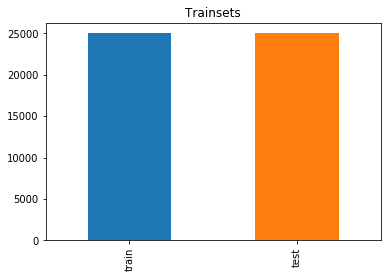

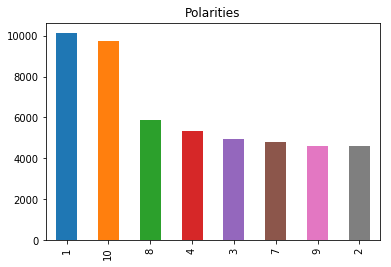

In [8]:
import matplotlib.pyplot as plt

dataframe['trainset'].value_counts().plot(kind='bar',title='Trainsets')
plt.show()

dataframe['polarity'].value_counts().plot(kind='bar',title='Polarities')
plt.show()

In [9]:
dataframe['review_size'] = dataframe['review'].apply(len)
dataframe['review_size'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_size, dtype: float64

In [10]:
dataframe[dataframe['review_size']==32]

,trainset,polarity,review,review_size
36517,test,2,"Read the book, forget the movie!",32


# pre processing

In [11]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(review):
    review = REPLACE_NO_SPACE.sub("", review.lower())
    review = REPLACE_WITH_SPACE.sub(" ", review)
    
    return review

dataframe['clean_review'] = dataframe['review'].apply(preprocess_reviews)

In [ ]:
dataframe

# training

In [12]:
train_reviews = dataframe[dataframe['trainset'] == 'train']['clean_review'].values.tolist()
train_classes = dataframe[dataframe['trainset'] == 'train']['polarity'].values.tolist()
test_reviews = dataframe[dataframe['trainset'] == 'test']['clean_review'].values.tolist()
test_classes = dataframe[dataframe['trainset'] == 'test']['polarity'].values.tolist()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

cv = CountVectorizer(binary=True)
cv.fit(train_reviews)
X = cv.transform(train_reviews)
X_test = cv.transform(test_reviews)

In [14]:
#save cv model
try:
    os.mkdir("models")
except FileExistsError:
    pass

s = pickle.dumps(cv)
with open('models/cv_pickle', 'wb') as pickle_file:
    pickle_file.write(s)

### parameters tunning

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, train_classes, train_size = 0.75
)

/Users/erick/virtualenvs/NLP-IA_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
for c in [0.001, 0.005, 0.009, 0.01, 0.015, 0.02, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    

In [17]:
final_model = LogisticRegression(C=0.009)
final_model.fit(X, train_classes)
print ("Final Accuracy: %s" 
       % accuracy_score(test_classes, final_model.predict(X_test)))

Final Accuracy: 0.42052


In [ ]:
# try SVM
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X, train_classes) 

# see the SVC parameters and try tunning them: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
print ("Final Accuracy SVM: %s" 
       % accuracy_score(test_classes, svm_model.predict(X_test)))

In [18]:
s = pickle.dumps(final_model)
with open('models/final_model', 'wb') as pickle_file:
    pickle_file.write(s)

# evaluation

In [19]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
#     ('excellent', 0.9288812418118644)
#     ('perfect', 0.7934641227980576)
#     ('great', 0.675040909917553)
#     ('amazing', 0.6160398142631545)
#     ('superb', 0.6063967799425831)
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)
    
#     ('worst', -1.367978497228895)
#     ('waste', -1.1684451288279047)
#     ('awful', -1.0277001734353677)
#     ('poorly', -0.8748317895742782)
#     ('boring', -0.8587249740682945)

('worst', 0.803209580402335)
('awful', 0.5351479745371935)
('waste', 0.48234284846444075)
('bad', 0.42465544907230046)
('terrible', 0.41194351340390667)
('best', -0.3889917433188075)
('great', -0.3746348095832253)
('excellent', -0.37156543140109943)
('the', -0.28493251615376536)
('and', -0.25938516915863147)


# deploying
install flask using ```pip3 install flask```. Let's create a REST service to make it available!
The following code must be put in a python file ```app.py```. In the same directory of the previous file, run the commands bellow:

```chmod +x app.py```

```python3 app.py```

In [22]:
def prepare_input(review):
    review = REPLACE_NO_SPACE.sub("", review.lower())
    review = REPLACE_WITH_SPACE.sub(" ", review)

    return cv.transform([review])
r = "best film ever!"
final_model.predict(prepare_input(r))[0]

'10'

In [ ]:
from flask import Flask
from sklearn.feature_extraction.text import CountVectorizer
import re
import pickle

# regular expressions
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

# load vectorization model
pickle_file = open('models/cv_pickle', 'rb')
cv = pickle.loads(pickle_file.read())

# load ML model
pickle_file = open('models/final_model', 'rb')
final_model = pickle.loads(pickle_file.read())


# prepare input to be classified
def prepare_input(review):
    review = REPLACE_NO_SPACE.sub("", review.lower())
    review = REPLACE_WITH_SPACE.sub(" ", review)

    return cv.transform([review])


app = Flask(__name__)

@app.route('/api/v1.0/scorefy/str:review')
def scorefy(review):
    return final_model.predict(prepare_input(review))[0]


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=3000, debug=True)
